# A/B Testing

In [10]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [11]:
effect_size = sms.proportion_effectsize(0.13,0.15)
required_n = sms.NormalIndPower().solve_power(effect_size,
                                             power = 0.8,
                                             alpha = 0.5,
                                             ratio = 1)

required_n = ceil(required_n)
print(required_n)

1280


In [12]:
df = pd.read_csv("ab_data.csv")

In [13]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [14]:
session_counts = df['user_id'].value_counts(ascending= False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times.')

There are 3894 users that appear multiple times.


In [15]:
dropping_users = session_counts[session_counts > 1].index
df = df[~df['user_id'].isin(dropping_users)]
df.shape[0]

286690

In [41]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state = 1)
treat_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state = 1)

ab_test = pd.concat([control_sample, treat_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)


In [17]:
ab_test['group'].value_counts()

treatment    1280
control      1280
Name: group, dtype: int64

In [28]:
conversion_rates = ab_test.groupby('group')['converted']
std_p = lambda x : np.std(x, ddof = 0)
sep_p = lambda x : stats.sem(x, ddof = 0)

conversion_rates = conversion_rates.agg([np.mean, std_p, sep_p])
conversion_rates.columns = ['conversion_rate','STDEV','STDERROR']

conversion_rates

,conversion_rate,STDEV,STDERROR
group,,,
control,0.121875,0.327141,0.009144
treatment,0.117969,0.322571,0.009016


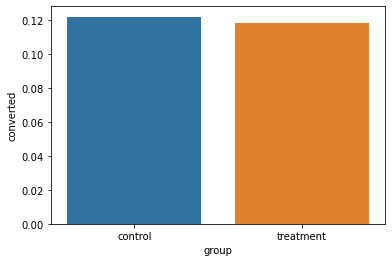

In [29]:
sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)

The control group performed much better than the treatment group. Is this difference statistically significant?

In [40]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treat_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treat_results.count()

successes = [control_results.sum(), treat_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


print(f'p-value:{pval}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

p-value:0.7609856665260438
ci 95% for control group: [0.104, 0.140]
ci 95% for treatment group: [0.100, 0.136]


P-value is greater than 0.05. We cannot reject the null hypothesis H0, new design is equivalent to the old page.

If we looked at the baseline of the confidence interval of the treatment group, it includes 13%, but does not include 15%. The CI for treatment group is also in the CI for the control group, further evidence that the treatment group performed roughly about the same as the control group. It is also evident that the CI for control group can reach up to 14% where the CI for treatment group does not, meaning the control group outperforms the treatment group.